In [1]:
import numpy as np
import os
from qcodes import Station
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.logger.logger import start_all_logging
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
import matplotlib.pyplot as plt
import scipy.signal as sp
from lab_qcodes import *

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/daniel/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /home/daniel/.qcodes/logs/200608-19583-qcodes.log


In [2]:
# Sempre importante iniciar o logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : /home/daniel/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /home/daniel/.qcodes/logs/200608-19583-qcodes.log


# Teste

In [3]:
PSG1 = DummySignalGenerator("SignalGenerator1",noise_function=np.zeros)
PSG2 = DummySignalGenerator("SignalGenerator2",noise_function=np.zeros)
PSG3 = DummySignalGenerator("SignalGenerator3",noise_function=np.zeros)
osc = DummyOscilloscope('oscilloscope')


In [4]:
aDUT = DUT("DUT",PSG1)
circuit = HomodyneCircuit("circuit",aDUT,PSG2)
circuit2 = HomodyneCircuit("circuit2",PSG1,PSG2)

In [5]:
osc.ch1.n_points(5000)
osc.ch2.n_points(5000)
osc.ch3.n_points(5000)
osc.ch4.n_points(5000)

osc.ch1.connect_inst(aDUT)
osc.ch2.connect_inst(PSG2)
osc.ch3.connect_inst(circuit)
osc.ch4.connect_inst(circuit2)
osc.ch1.t_start.set(-10)
osc.ch1.t_stop.set(10)
osc.ch2.t_start.set(-10)
osc.ch2.t_stop.set(10)
osc.ch3.t_start.set(-10)
osc.ch3.t_stop.set(10)
osc.ch4.t_start.set(-10)
osc.ch4.t_stop.set(10)


# Homodyne 

In [6]:
amp = 1
PSG1.amp(amp)
PSG2.amp(amp)

# Teste Medida 

In [7]:
# Station representa um conjunto de instrumentos
station = Station()
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'config': None,
 'default_measurement': []}

In [8]:
station.add_component(osc)

'oscilloscope'

In [9]:
# Criar um database
initialise_or_create_database_at("~/teste.db")

In [10]:
#Definir um experimento
exp = load_or_create_experiment(experiment_name='osc_teste dut',
                                sample_name="osc teste 1")

In [11]:
phaseGain = Parameter('phaseGain',
                  label='Phase Gain',
                  unit='rad',
                  get_cmd=None)

gain = Parameter('gain',
                  label='gain',
                  unit='dB',
                  get_cmd=None)

def calculateDC():
    Y = osc.ch3.wavesample()
    n_mean = int(len(Y)/2)
    value = 2*np.mean(Y[n_mean:])
    return value

GAIN

In [59]:
# Medida de fato
meas = Measurement(exp=exp, station=station)

meas.register_parameter(PSG1.freq)
meas.register_parameter(gain, setpoints=[PSG1.freq])

aDUT.omega0(200)


with meas.run() as datasaver:
    for aFreq in np.linspace(1,500,500):
        PSG1.freq(aFreq)
        PSG2.freq(aFreq)
        
        PSG2.phase(0)
        I = calculateDC()
        
        PSG2.phase(np.pi/2)
        Q = calculateDC()
        
        gainValue = np.sqrt(I**2+Q**2)
        value = 10*np.log(np.power(gainValue,2))
        
        datasaver.add_result((gain, value), (PSG1.freq, PSG1.freq()))
        
dataset = datasaver.dataset

Starting experimental run with id: 8. 


([<matplotlib.axes._subplots.AxesSubplot at 0x7f1518aeab70>], [None])

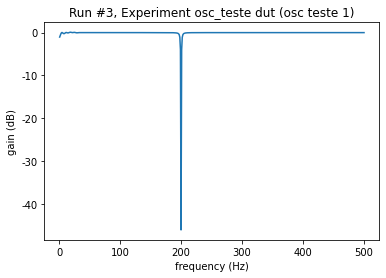

In [13]:
plot_dataset(dataset)

PHASE

In [29]:
# Medida de fato
meas = Measurement(exp=exp, station=station)

meas.register_parameter(PSG1.freq)
meas.register_parameter(phaseGain, setpoints=[PSG1.freq])

aDUT.omega0(200)

with meas.run() as datasaver:
    for aFreq in np.linspace(1,500,500):
        PSG1.freq(aFreq)
        PSG2.freq(aFreq)
        
        PSG2.phase(0)
        I = calculateDC()
        
        PSG2.phase(np.pi/2)
        Q = calculateDC()
        
        phaseValue = np.arctan(Q/I)
        
        datasaver.add_result((phaseGain, phaseValue), (PSG1.freq, PSG1.freq()))
        
dataset = datasaver.dataset

Starting experimental run with id: 7. 


([<matplotlib.axes._subplots.AxesSubplot at 0x7f1518522c50>], [None])

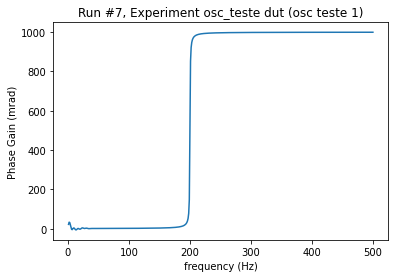

In [30]:
plot_dataset(dataset)

lista de experimentos

In [43]:
import qcodes as qc
from qcodes.dataset.plotting import plot_dataset

In [44]:
qc.initialise_or_create_database_at("~/teste.db")

In [45]:
experiments = qc.experiments()
for exp in experiments:
    print(exp.name)

osc_teste dut


In [46]:
use_exp = experiments[-1];use_exp

osc_teste dut#osc teste 1#1@/home/daniel/teste.db
-------------------------------------------------
1-results-1-SignalGenerator1_freq,gain-500
2-results-2-SignalGenerator1_freq,phaseGain-500
3-results-3-SignalGenerator1_freq,gain-500
4-results-4-SignalGenerator1_freq,phaseGain-500
5-results-5-SignalGenerator1_freq,gain-500
6-results-6-SignalGenerator1_freq,phaseGain-500
7-results-7-SignalGenerator1_freq,phaseGain-500

In [64]:
use_exp.data_sets()

[results #1@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 gain - numeric,
 results #2@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 phaseGain - numeric,
 results #3@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 gain - numeric,
 results #4@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 phaseGain - numeric,
 results #5@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 gain - numeric,
 results #6@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 phaseGain - numeric,
 results #7@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 phaseGain - numeric,
 results #8@/home/daniel/teste.db
 --------------------------------
 SignalGenerator1_freq - numeric
 gain - numeric]

In [66]:
#pega tabela em texto com os datasets do experimento e transforma em string
table=str(use_exp)
#tranforma table em um vetor com as linhas
lines=table.splitlines()
#remove a primeira e segunda linhas
del lines[0]
del lines[0]

#pega o ultimo dataset do experimento
stringdts=lines[-1]
#para pegar o captured runID a partir do string de selecao
#particiona o vetor no primeiro '-' que aparece e pega a primeira parte[0]
dts = stringdts.partition('-')[0]
#converte de string para int
dts=int(dts); print(dts)


8


In [67]:
dataset = qc.load_by_run_spec(experiment_name=use_exp.name,  captured_run_id=dts)

([<matplotlib.axes._subplots.AxesSubplot at 0x7f15181a2b00>], [None])

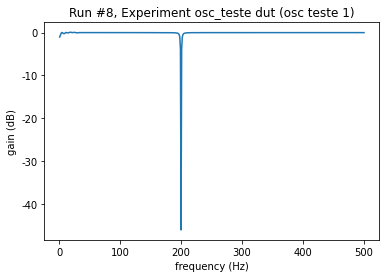

In [68]:
qc.dataset.plotting.plot_dataset(dataset)

real time plot

In [57]:
from jupyterplot import ProgressPlot
import qcodes as qc
import numpy as np
import time

In [76]:
use_exp

osc_teste dut#osc teste 1#1@/home/daniel/teste.db
-------------------------------------------------
1-results-1-SignalGenerator1_freq,gain-500
2-results-2-SignalGenerator1_freq,phaseGain-500
3-results-3-SignalGenerator1_freq,gain-500
4-results-4-SignalGenerator1_freq,phaseGain-500
5-results-5-SignalGenerator1_freq,gain-500
6-results-6-SignalGenerator1_freq,phaseGain-500
7-results-7-SignalGenerator1_freq,phaseGain-500
8-results-8-SignalGenerator1_freq,gain-500

In [74]:
#escolha um dataset gerado acima com gain ao inves de phase gain
crid=8
dataset = qc.load_by_run_spec(experiment_name=use_exp.name,  captured_run_id=(crid))

In [75]:
dataset

results #5@/home/daniel/teste.db
--------------------------------
SignalGenerator1_freq - numeric
gain - numeric

In [60]:
pp = ProgressPlot(x_iterator=False,x_lim=[0, 500], y_lim=[-200, 200])

Y = dataset.get_parameter_data('gain')['gain']['gain']
X = dataset.get_parameter_data('gain')['gain']['SignalGenerator1_freq']
aLen = len(Y)

for i in range(0,aLen):
        pp.update(X[i],Y[i])

while aLen != 500:
    time.sleep(0.1)
    
    Y = dataset.get_parameter_data('gain')['gain']['gain']
    X = dataset.get_parameter_data('gain')['gain']['SignalGenerator1_freq']

    newLen = len(Y)
    for i in range(aLen,newLen):
        pp.update(X[i],Y[i])
        
    aLen = newLen
    
pp.finalize()